In [6]:
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
using LsqFit
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf

nthreads = 1


In [51]:
e = -1
m = 1

1

In [25]:
include("aux_functions_vlasov.jl")

counter_streams_rel_dist

In [81]:
file_name = "Results/l_two_streams_1000_400_v_02_n4_o4_Th005.jld2"

data = load(file_name);
run_name = data["run_name"]
p_Ini = data["p_Ini"]
(Nx, dx, Np, dp) = data["par_grid"]
(t_i, t_f, M, M_g, dt) = data["par_evolv"]

Lx = (Nx-1)*dx
Lp = (Np-1)*dp/2
κ = 2π/Lx
x = [(i-1)*dx for i in 1:Nx]
p = [get_p(j,dp,Np)/m for j ∈ 1:Np]
v = [p[j]/sqrt(1+p[j]^2) for j ∈ 1:Np];



M_g = 350 # mas grandes son NAN

v = zeros(Nx*(Np+1),M_g)

for j in 1:M_g
    tiempo = @sprintf("%05d", j)
    v[:,j] = data["u/u_$tiempo"]
end

In [82]:
plots = true

true

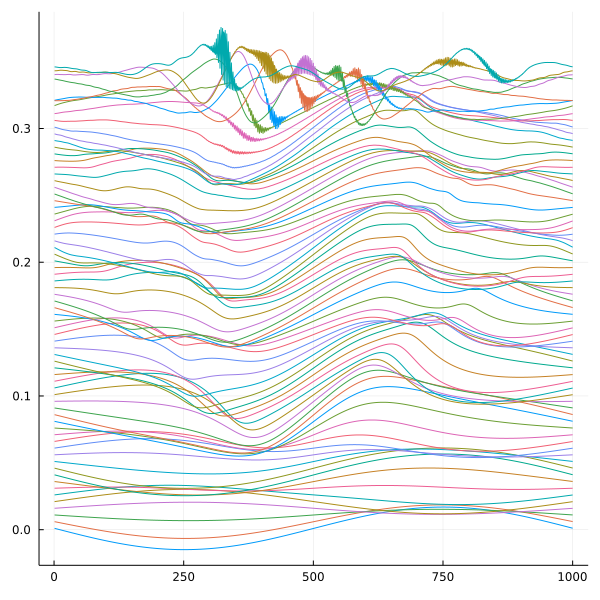

In [83]:
if plots 
    ofset = 0.001
    plt = plot(label="Electric Field", legend=false)
    for j in 1:5:(M_g)
        plt = plot!(v[Nx*Np+1:end,j].+ofset*j)
    end
    plt
    #png("electric_field_" * run_name)
end

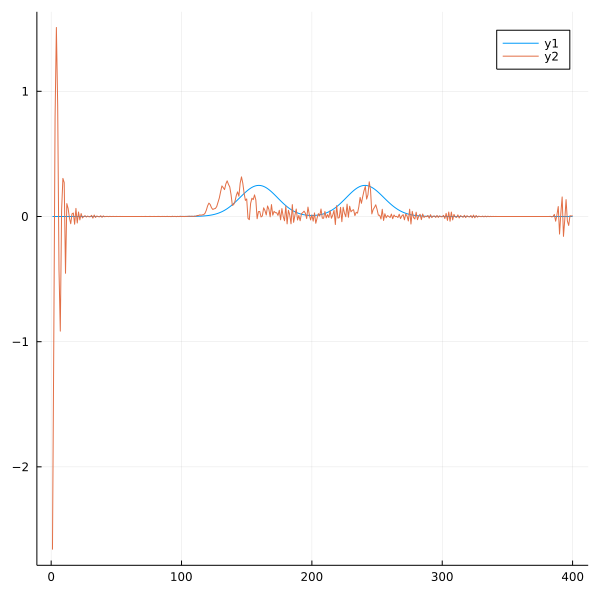

In [87]:
if plots
    F = reshape(v[1:Nx*Np,:],(Nx,Np,M_g));

    plot(F[Nx÷2,:,1])
    plot!(F[Nx÷2,:,330])
    #plot_matrix(F[1:2:end,1:2:end,1]) #sparse version
    #plot_matrix(F[:,:,1])
    #png("initial_dist_" * run_name)
end

In [91]:
if plots
    plot_matrix(F[:,:,end], title="t=$t_f")
    png("final_dist_" * run_name)
end

In [90]:
if plots
    heatmap(F[:,:,end],
        #c = cgrad([:blue,:white,:red]),
        fc = :ocean,
        linealpha = 0.8, fillalpha=0.8,
        yflip = true,
        xlabel = "p", ylabel = "x",
        title = "Distribution function at t = $(t_f)"
    )

    png("final_conf_heat_" * run_name)
end

n0 = -0.9778605600108989


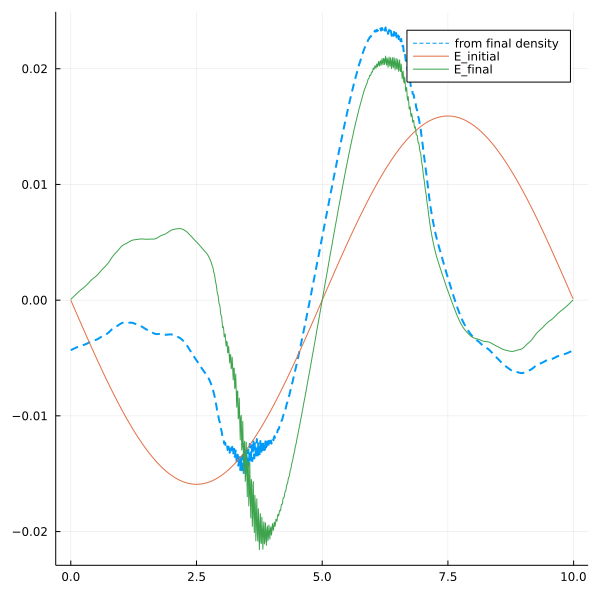

In [96]:
ρ_f = zeros(Nx)
E_f = zeros(Nx)
E_i = v[Nx*Np+1:end,1]
ϕ_f = zeros(Nx)
S_f = zeros(Nx)

j = 310

get_density!(v[:,j], ρ_f, (Nx, dx, Np, dp, m, e))
n0 = get_total_density!(ρ_f, (Nx, dx))
println("n0 = $(n0)")
get_ϕ!(ϕ_f, ρ_f .- e*n0, κ)
get_E_from_ϕ!(ϕ_f,E_f,dx)

if plots
    plot(x,E_f,label="from final density", ls=:dash, lw=2)
    plot!(x,E_i,label="E_initial")
    plot!(x,v[Nx*Np+1:end,j], label="E_final"
    )

    #png("Efield_th$(nthreads())_" * run_name)
end


In [97]:
Energy_K = zeros(M_g)
Energy_E = zeros(M_g)
EField_T = zeros(M_g)
p_T = zeros(M_g)
n_T = zeros(M_g)
S_T = zeros(M_g)
E_E = 0.0
E_K = zeros(Nx)
P = zeros(Nx)
ρ = zeros(Nx)
S = zeros(Nx)

for j in 1:M_g
    Energy_K[j]  = sum(get_K_energy!(v[:,j],E_K,(Nx, dx, Np, dp)))*dx
    Energy_E[j]  = get_E_energy(v[:,j],(Nx, dx))
    EField_T[j] = sum(v[Nx*Np+1:end,j])*dx
    p_T[j] = sum(get_momentum!(v[:,j],P,(Nx, dx, Np, dp)))*dx

    get_density!(v[:,j], ρ, (Nx, dx, Np, dp, m, e))
    get_current!(v[:,j], S, (Nx, dx, Np, dp, v, m, e))
    n_T[j] = get_total_density!(ρ,(Nx, dx))
    S_T[j] = sum(S)/n_T[j]/Nx
end

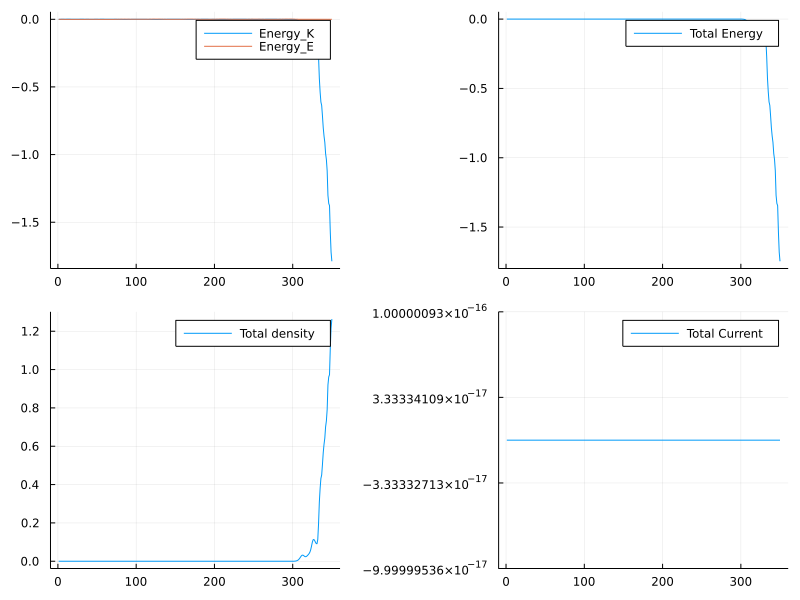

In [98]:

if plots 
    factor = 200
    plot(layout=(2,2), size=(800,600))
    plot!(subplot=1, (Energy_K[1:end] .- Energy_K[1]), label="Energy_K")
    plot!(subplot=1, (Energy_E .- Energy_E[1]), label="Energy_E")
    #plot!(subplot=1, Energy_K, label="Energy_K")
    #plot!(subplot=1, Energy_E[1:400], label="Energy_E")
    plot!(subplot=2, (Energy_K + Energy_E) ./ (Energy_K[1] + Energy_E[1]) .- 1, label="Total Energy")
    plot!(subplot=3, n_T .+ 1.0, label="Total density")
    plot!(subplot=4, S_T, label="Total Current")

    #png("total_conf_" * run_name)
end

In [ ]:

p0 = [7.90*10^(-5); 0.561111]
@. model(x, p) = p[1]*cos(x*p[2])^2 #* exp(-x*p[3]) #*cos(x*p[5] + p[6])

In [ ]:
t_series = [dt*(i-1)*((M-1)÷(M_g-1)) for i in 1:M_g];
fit = curve_fit(model, t_series, data_2["Energy_E"], p0);
fit.param

In [ ]:
p1 = 7.90*10^(-5); p2 = 0.561111
plot(t_series, data_2["Energy_E"])
#plot!(t_series, model(t_series, fit.param))
plot!(t_series, p1*cos.(p2*t_series).^2)

Fit for undamped with parameters:



$p1 = 7.90*10^{-5}$  $p2 = 0.561111$ for $E_E(t) = p1\; cos(p2*t)^2$


Los parámetros de fiteo son: 

### Caso undamped n = 4

    Lx = 39.738, Nx = 3522, Np = 200, Lp = 0.5

    α = 0.01
    n = 4 (chekeado que la longitud de onda es Lx/4)
    k = 2*π*n/Lx
    θ = 0.001

$E_K = a + b*cos(\omega*t + \alpha)^2$ 

Tenemos $a = 1.0005005$, $b = 0.0000196$ $\omega = 0.562$, $\alpha = -\pi/2$

$E_K = a' + d'*cos(\omega' * t + \alpha')$ 

Tenemos $a'= 1.0005103$, $b'= 0.0000196/2$ $\omega' = 0.562*2$ $\alpha'= - π$

$E_E = p_1 * cos(p_2 * t)^2

Tenemos $p_1 = 1.969*10^{-5} $, $p_2 = 0.5619$ 

### Caso undamped n = 2

Lx = 39.738, Nx = 3522, Np = 200, Lp = 0.5

    α = 0.01
    n = 2 (chekeado que la longitud de onda es Lx/2)
    k = 2*π*n/Lx
    θ = 0.001

Tenemos $p1 = 7.90*10^{-5}$  $p2 = 0.561111$ for $E_E(t) = p1\; cos(p2*t)^2$

$\omega = \; \sqrt{4π} * 0.561111 \;= \;1.989 $


**No entiendo porque no cambian las frequencias entre n = 2 y 4. Bueno, según SHARP comienza cuadrático, puede ser que este bien**

### Caso damped

    Lx = 7.455, Nx = 930, Np = 200, Lp = 0.5

    α = 0.01
    n = 15
    k = 2*π*n/Lx
    θ = 0.001

$E_E = b*cos(\omega*t)^2 e^{-\gamma * t}$ 

Tenemos: $b = 1.450 \; 10^{-7}$, $\omega = 1.512$, $\gamma = 0.03$


#### Note: 

Since we are using a $4\pi$ in the equation for E dot, we need to change E and t to get to the equations in the SHARP paper, for that we have to change time by a factor $\sqrt{4\pi}$. 

$$
\hat t = a t \;\;\;\; \partial_{\hat t} = \frac{1}{a} \partial_t 
$$

\begin{align*}
\partial_t f &= a \partial_{\hat t} f = E \partial_p f = a \hat{E} \partial_p f \\
\partial_t E &= a^2 \partial_{\hat t} \hat{E} = 4\pi S
\end{align*}

Therefore $a^2 = 4\pi$ (the hat variables are the ones in the SHARP paper), or $\hat t = \sqrt{4\pi} t$, or 
$\hat{\omega} = \omega /\sqrt{4\pi}$


Using this factor we get:

#### undamped: #### 

$\hat{\omega} = \;  0.562  / \sqrt{4π} \;= \;0.15828 $

#### damped: #### 

$\hat{\omega} = 1.512 / \sqrt{4π} = 0.42652$, $\hat{\gamma} =  0.03 / \sqrt{4π} = 0.008$


We also have: 

$$
\frac{\omega_{15}}{\omega_4} = 2.6905 \;\;\;\;\;\;\; \frac{\gamma_{15}}{\omega_4} = 0.053
$$

In [ ]:
 0.03 / sqrt(4π)
 0.03 / 0.562
 2.69 / 2

In [ ]:
plot(data_2["S_F"])

In [ ]:
data_4 = load("fine_landau_3522_200_alp2_n_Th3th1_results.jld2")

In [ ]:
plot(data_4["S_F"])

In [ ]:
p_4_1 = 1.969*10^(-5) ; p_4_2 = 0.5619
plot(t_series, data_4["Energy_E"])
plot!(t_series, p_4_1 * cos.(p_4_2 * t_series).^2)